# Prepear

In [3]:
# https://bamblebam.medium.com/audio-classification-and-regression-using-pytorch-48db77b3a5ec
# The above code will import all the necessary libraries and initialize your device to either CPU or GPU. 

import torchaudio as ta
from torch.utils.data import DataLoader
import numpy as numpy

import numpy as np
import pandas as pd

import tqdm as tqdm

import torch
from torch import nn
import torchaudio

# # Debug mode: reload datafram
# import importlib
# importlib.reload(datafram)
# import datafram

from datafram import dataset, SAMPLE_RATE, NUM_SAMPLES, BATCH_SIZE

import cnn

if torch.cuda.is_available():
    print('yes')
    device='cuda'
else:
    device='cpu'

import torch
from cnn import CNNetwork
import torchaudio
import os

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from glob import glob
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import pylab
import itertools

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device is cpu


In [4]:
from pathlib import Path
ESTIMATES_DIR = Path("output") / "estimates" / "deep_mask"

AUDIO_DIR = r"audio"  # Audio files location

In [5]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

usd = dataset(AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)
print(f"There are {len(usd)} samples in the dataset")

# Split the dataset into train and validetion sets
train_dataset, validetion_dataset = train_test_split(usd, train_size=0.7, test_size=0.3, random_state=0, shuffle=True)
validetion_dataset, test_dataset = train_test_split(validetion_dataset, test_size=0.5, train_size=0.5, random_state=0, shuffle=True)

# Create data loader for the train dataset
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

print(f"There are {len(train_dataset)} samples in the train dataset")
print(f"There are {len(validetion_dataset)} samples in the validetion dataset")
print(f"There are {len(test_dataset)} samples in the test dataset")

# Create train loader
train_dataloader = create_data_loader(train_dataset, BATCH_SIZE)

# Create validetion loader
validetion_dataloader = create_data_loader(validetion_dataset, BATCH_SIZE)

# Create test loader
test_dataloader = create_data_loader(test_dataset, BATCH_SIZE)


There are 420 samples in the dataset


There are 294 samples in the train dataset
There are 63 samples in the validetion dataset
There are 63 samples in the test dataset


C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:2009: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Train and Validetion

In [32]:
def map_values_to_keys(lst):
    value_to_key = {}
    mapped_list = []
    current_key = 0
    
    for value in lst:
        if value not in value_to_key:
            value_to_key[value] = current_key
            current_key += 1
        mapped_list.append(value_to_key[value])
    
    return mapped_list

# Train a single epoch
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    calc_accuracy = 0.0
    calc_loss = 0.0

    model.train()

    for inputs, targets in data_loader:
        # inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        targets = map_values_to_keys(targets)
        loss = loss_fn(predictions, torch.tensor(targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        calc_loss += loss.cpu().data * inputs.size(0)
        _, prediction = torch.max(predictions.data, 1)

    print(f"Loss: {loss.item()}, Calc_accuracy: {calc_accuracy}")
    return calc_accuracy, calc_loss

# Main train function
def training(train_loader, train_values, validetion_values, loss_fn, device, epochs):
    learning_rates = [0.1, 0.01, 0.001, 0.0001]
    Models = []
    train_err = torch.zeros(len(learning_rates))
    validetion_err = torch.zeros(len(learning_rates))
    best_accuracy = 0.0

    for i, learning_rate in enumerate(learning_rates):
        # Build the model
        model = cnn.CNNetwork().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.05)
        # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)

        for j in range(epochs):
            print(f"Epoch {j+1}")
            calc_accuracy, calc_loss = train_single_epoch(model, train_loader, loss_fn, optimizer, device)
            print("---------------------------------")


        # training data
        Y_hat = model(torch.stack(train_values["x"]))
        train_loss = loss_fn(Y_hat, torch.Tensor(map_values_to_keys(train_values["y"])).long())
        train_err[i] = train_loss.item()
    
        # validation data
        Y_hat = model(torch.stack(validetion_values["x"]))
        val_loss = loss_fn(Y_hat, torch.Tensor(map_values_to_keys(validetion_values["y"])).long())
        validetion_err[i] = val_loss.item()
        Models.append(model)

    print("Training is done")

    err = min(validetion_err)
    model = Models[list(validetion_err).index(err)]

    return model, err, calc_loss 

In [33]:
from collections import defaultdict
from importlib import reload
reload(cnn)

# Constants

EPOCHS = 100

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn=torch.nn.MSELoss() 

train_values = defaultdict(list)
for inputs, target in train_dataloader.dataset:
    train_values["x"].append(inputs)
    train_values["y"].append(target)

validetion_values = defaultdict(list)
for inputs, target in validetion_dataloader.dataset:
    validetion_values["x"].append(inputs)
    validetion_values["y"].append(target)

# Train the model
model, err, calc_loss = training(train_dataloader, train_values, validetion_values, loss_fn, device, EPOCHS)

# Save the trained model
torch.save(model.state_dict(), "best_model_cnnet.pth")
print('Model trained and stored at cnnet.pth')


Epoch 1
Loss: 1.2356553077697754, Calc_accuracy: 0.0
---------------------------------
Epoch 2
Loss: 1.235655426979065, Calc_accuracy: 0.0
---------------------------------
Epoch 3
Loss: 1.235655426979065, Calc_accuracy: 0.0
---------------------------------
Epoch 4
Loss: 1.2356553077697754, Calc_accuracy: 0.0
---------------------------------
Epoch 5
Loss: 1.235575795173645, Calc_accuracy: 0.0
---------------------------------
Epoch 6
Loss: 1.261876106262207, Calc_accuracy: 0.0
---------------------------------
Epoch 7
Loss: 1.234857439994812, Calc_accuracy: 0.0
---------------------------------
Epoch 8
Loss: 1.1666274070739746, Calc_accuracy: 0.0
---------------------------------
Epoch 9
Loss: 1.209389090538025, Calc_accuracy: 0.0
---------------------------------
Epoch 10
Loss: 1.1830238103866577, Calc_accuracy: 0.0
---------------------------------
Epoch 11
Loss: 1.1830238103866577, Calc_accuracy: 0.0
---------------------------------
Epoch 12
Loss: 1.183092474937439, Calc_accuracy

## Test

In [37]:
from sklearn.preprocessing import LabelEncoder

def binary_encoding(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    return y

# When we deal with NN , the NN know nothing about the name of the classes we work with, 
# what we need is to creat a mapping between the integers and the maps.
def count_objects(folder_path):
    object_names = []
    for entry in os.scandir(folder_path):
        if entry.is_dir():
            object_names.append(entry.name)
    return object_names

folder_dir = os.path.join(AUDIO_DIR)
class_mapping = count_objects(folder_dir)


def map_values_to_keys(lst):
    value_to_key = {}
    mapped_list = []
    current_key = 0
    
    for value in lst:
        if value not in value_to_key:
            value_to_key[value] = current_key
            current_key += 1
        mapped_list.append(value_to_key[value])
    
    return value_to_key

# For Nmist this is a bit over kill due to the nmist infrustructors
# Nmist is a data set witch containse digits -> at index 0 we have digit 0 and so one 



def predict (model, input, target, class_mapping):
    # model == pytorch model
    # .eval() == mathoud a swift that change how pytorch model behave
    #            if we activate it a sertion layers such as dropout buth_normalizetion drop off (becouse we dont need them for evaluations)
    # we will call eval every time we need to do evaluation or infreance
    # .train() == the opesite switch if we want to come back to train    
    model.eval() 

    # Contant manger thet come directly with pytourch 
    # the model doesent calculated any gredent(???) and this is good when we do valuation (grediant needed only when we doing treaning)
    with torch.no_grad():
        predictions = model(input)
        #Tenser object with a specific dimention Tensar (#number of input, # number of class)
        # for us Tenser (1,10) -> [0.1, 0.01, ...., 0.6 ] ## remmember the sum need to be equel to 1 becouse we are using soft_math
        # We are intrest in the index how has the highest value (this is teh class we indecad)
        predicted_index = predictions[0].argmax(0) # 0 replace the first prediction only the sample we predectex, and teh max valu of it 
        predicted = class_mapping[predicted_index]        
        targets = map_values_to_keys(class_mapping)

        def get_key_from_value(value, value_to_key_map):
            for key, val in value_to_key_map.items():
                if key == value:
                    return val
            return None

        target_map = get_key_from_value(target, targets)
        expected = class_mapping[target_map]
    return predictions, predicted, expected


In [45]:
class_mapping

['clapp', 'cough', 'viola']

In [34]:
# if __name__ == "__main__":
import cnn
from importlib import reload
reload(cnn)

# load back the model
model = CNNetwork()
state_dict = torch.load("best_model_cnnet.pth") #load fiel that contain all the info on teh trained model
model.load_state_dict(state_dict)

# load uraban sound dataset validation dataset
# instantiating our dataset object and create data loader
# if equels -> one second equel 'one audio'

# Documentetion: https://pytorch.org/audio/stable/transforms.html
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

# Define the transformations
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

test = dataset(ESTIMATES_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)
len(test)
print(f"There are {len(usd)} samples in the dataset")

# # Debug mode
# get a sample from the urbansound dataset for inference
# Get the input as well as the target conacted to the sample 
# to compare between what we get to what we expect 
# input, target = usd[1340][0], usd[1340][1]

Device is cpu
There are 420 samples in the dataset


In [35]:
usd[0][0].shape


torch.Size([1, 64, 44])

In [38]:
test_samples = list(test_dataloader)
predicteds = []
expecteds = []
predictions = []
for branch in range(len(test_samples)):
    for item in range(len(test_samples[branch][0])):
        input, target = test_samples[branch][0][item], test_samples[branch][1][item] 
        # NOTE:from teh validatition dawe take the first input [0][ ] 
        #       as well as the input [ ][0]
        #       and the target to thi validation input [ ][1]
        input.unsqueeze_(0)
        #NOTE: [batch size, num_channels, fr, time]
        #       so we will insert a third dimention in the input dimention

        # make an inference
        prediction, predicted, expected = predict(model, input, target,class_mapping)
        print(branch, item)
        print (f"Predicted: '{predicted}', expected: '{expected}")
        
        predictions.append(prediction)
        predicteds.append(predicted)
        expecteds.append(expected)

0 0
Predicted: 'viola', expected: 'cough
0 1
Predicted: 'clapp', expected: 'clapp
0 2
Predicted: 'cough', expected: 'viola
0 3
Predicted: 'cough', expected: 'viola
0 4
Predicted: 'cough', expected: 'cough
0 5
Predicted: 'cough', expected: 'viola
0 6
Predicted: 'cough', expected: 'cough
0 7
Predicted: 'viola', expected: 'clapp
0 8
Predicted: 'cough', expected: 'cough
0 9
Predicted: 'cough', expected: 'cough
0 10
Predicted: 'viola', expected: 'clapp
0 11
Predicted: 'cough', expected: 'viola
0 12
Predicted: 'cough', expected: 'cough
0 13
Predicted: 'cough', expected: 'cough
0 14
Predicted: 'cough', expected: 'viola
0 15
Predicted: 'viola', expected: 'clapp
0 16
Predicted: 'cough', expected: 'cough
0 17
Predicted: 'clapp', expected: 'clapp
0 18
Predicted: 'cough', expected: 'viola
0 19
Predicted: 'viola', expected: 'cough
0 20
Predicted: 'viola', expected: 'clapp
0 21
Predicted: 'cough', expected: 'viola
0 22
Predicted: 'cough', expected: 'cough
0 23
Predicted: 'cough', expected: 'viola
0 

# Confusion matrix and ROC
    Load predicted labels (y_pred) from a numpy file.
    Get a list of file paths for the .wav files in a specified directory.
    Sort the file paths and extract the classes from the file paths.
    Encode the true labels (labels) using a LabelEncoder.
    Convert the encoded labels (y_true) into one-hot encoded vectors (y_hot) using to_categorical.
    Compute the Receiver Operating Characteristic (ROC) curves and areas under the curves for each class.
    Compute the micro-average ROC curve and area under the curve.
    Aggregate false positive rates and interpolate all ROC curves.
    Compute the macro-average ROC curve and area under the curve.
    Plot the micro-average and macro-average ROC curves, as well as individual ROC curves for each class.
    Compute the confusion matrix using the true and predicted labels.
    Create a heatmap of the confusion matrix using seaborn library for visualization.
    The code uses various libraries such as numpy, glob, os, sklearn, matplotlib, pylab, pandas, and seaborn to perform these tasks.

In [39]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
y_pred = np.array(predictions[0])

In [41]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(class_mapping)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(class_mapping)

3 classes: clapp, cough, viola


# Confusion Matrix

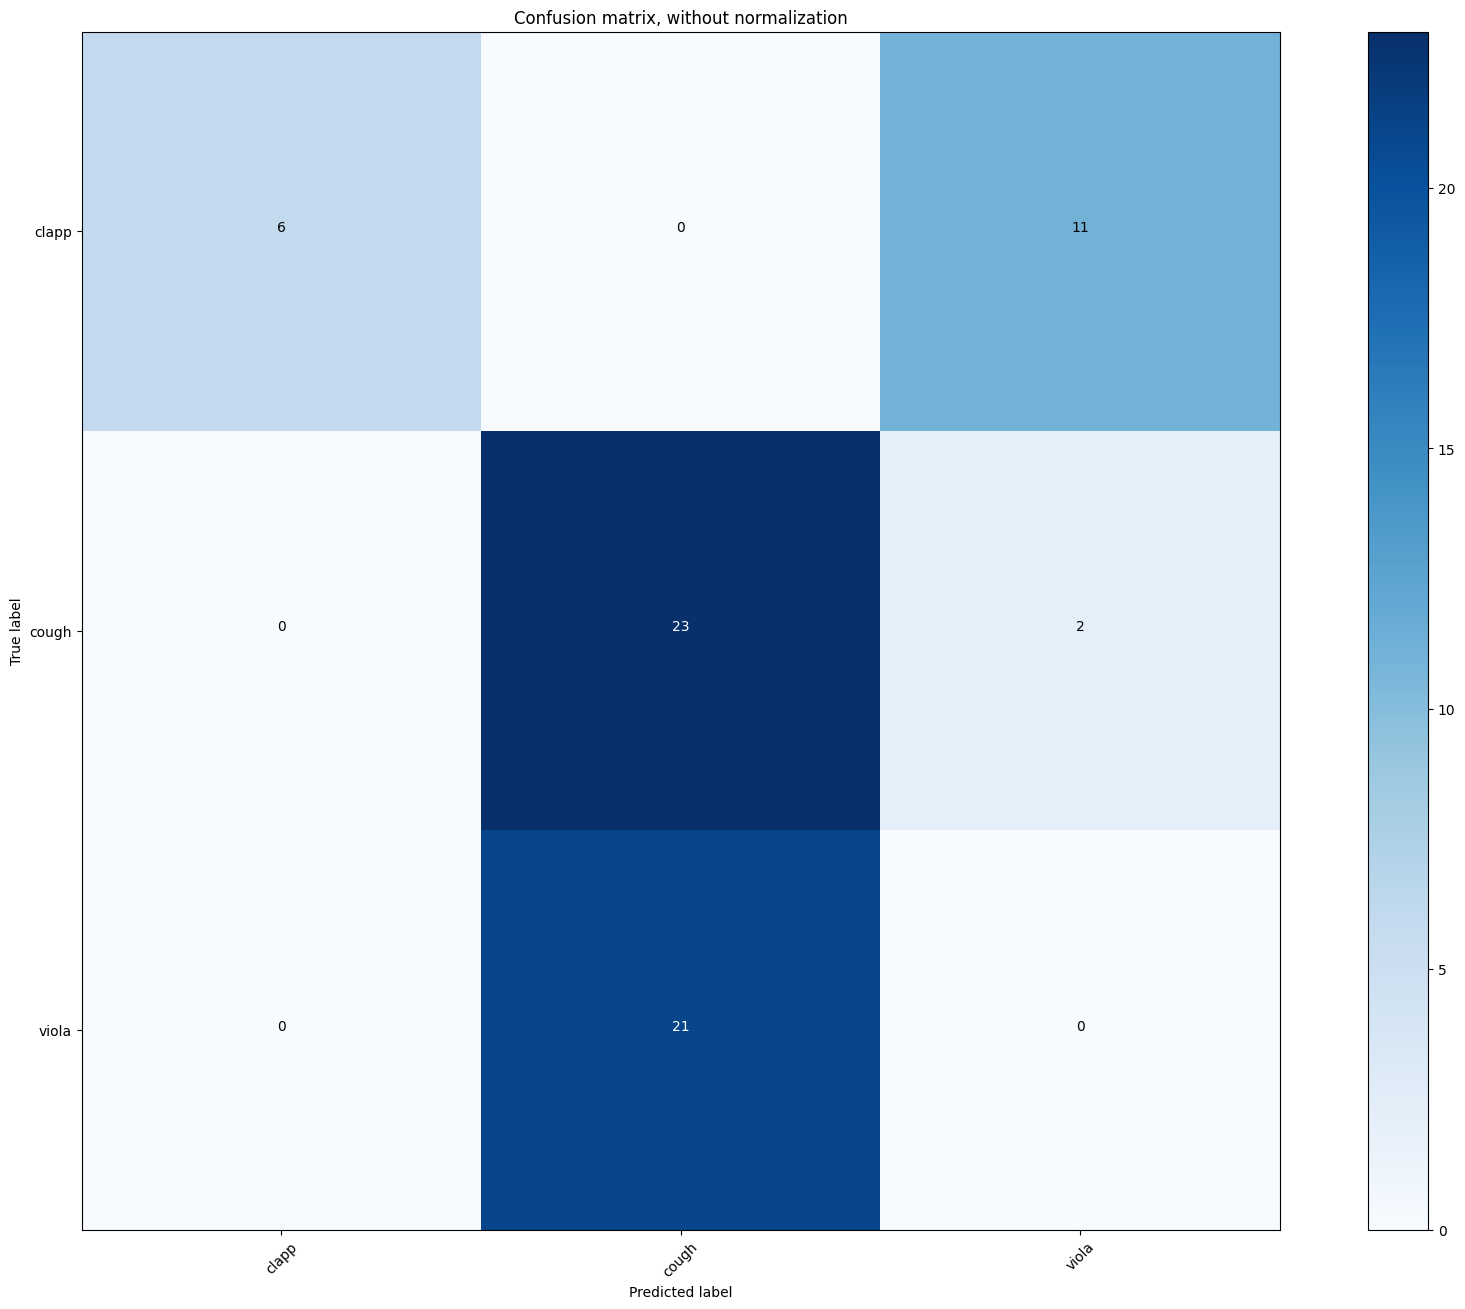

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(expecteds, predicteds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [16]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tempfile
import copy
import tqdm


to_numpy = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).reshape(-1, 1).float()

In [ ]:
N_ITER=100
LEARNING_RATE = 0.01
# initialize line
line = Line()

frames = []
@gif.frame
def plot(i):
    y_hat = line(to_tensor(x))
    plt.figure(dpi=300)
    plt.title(
        f"Training data + network predictions\n"
        f"Learning rate is {LEARNING_RATE}, Iteration {i}")

    plt.scatter(x, y, label='Training data')
    plt.scatter(x, to_numpy(y_hat), label='Network predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-10, 10])
    plt.ylim([-20, 20])
    plt.legend()

for i in range(N_ITER):
    line.zero_grad()
    y_hat = line(to_tensor(x))
    _loss = (y_hat - to_tensor(y)).abs().mean()
    _loss.backward()
    
    for n, p in line.named_parameters():
        p.data += - LEARNING_RATE * p.grad
    
    frame = plot(i)
    frames.append(frame)

# show_gif(frames)

In [ ]:
N_ITER=100
LEARNING_RATES = [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001]

line = Line()
lines = [copy.deepcopy(line) for _ in LEARNING_RATES]

losses = [[] for _ in range(len(LEARNING_RATES))]
grad_norms = [[] for _ in range(len(LEARNING_RATES))]

frames = []
@gif.frame
def plot(i, lines):
    ncols = 3
    nrows = len(LEARNING_RATES) // ncols
    width = ncols * 5
    height = nrows * 4
    fig, axs = plt.subplots(nrows, ncols, dpi=100, figsize=(width, height))
    axs = axs.flatten()
    
    for j, line in enumerate(lines):
        y_hat = line(to_tensor(x))
        axs[j].set_title(
            f"Training data + network predictions\n"
            f"Learning rate is {LEARNING_RATES[j]}, Iteration {i}")
        axs[j].scatter(x, y, label='Training data')
        axs[j].scatter(x, to_numpy(y_hat), label='Network predictions')
        axs[j].set_xlabel('x')
        axs[j].set_ylabel('y')
        axs[j].legend()
        axs[j].set_xlim([-10, 10])
        axs[j].set_ylim([-20, 20])
        
    plt.tight_layout()

for i in range(N_ITER):
    for j, line in enumerate(lines):
        line.zero_grad()
        y_hat = line(to_tensor(x))
        _loss = (y_hat - to_tensor(y)).abs().mean()
        losses[j].append(_loss)
        _loss.backward()
        
        grad_norm = 0
        for n, p in line.named_parameters():
            p.data += - LEARNING_RATES[j] * p.grad
            grad_norm += (p.grad.sum() ** 2)
        grad_norm = grad_norm.sqrt().item()
        grad_norms[j].append(grad_norm)

    frame = plot(i, lines)
    frames.append(frame)

# show_gif(frames, width=1200)

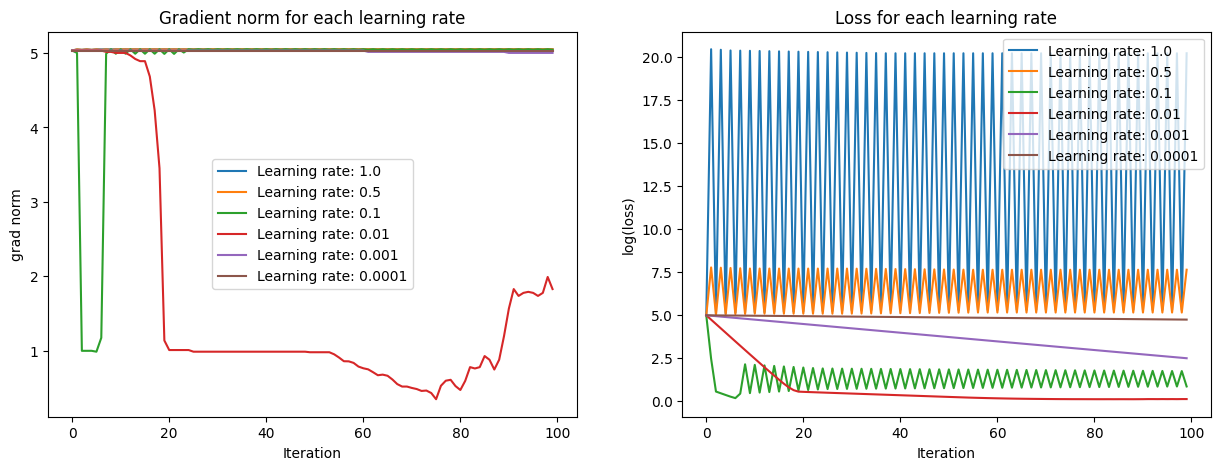

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for j, lr in enumerate(LEARNING_RATES):
    ax[0].plot(grad_norms[j], label=f'Learning rate: {lr}')
    ax[0].legend()
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('grad norm')
    ax[0].set_title('Gradient norm for each learning rate')
    
for j, lr in enumerate(LEARNING_RATES):
    tensor_list = losses[j]
    np_array = np.array([tensor.detach().numpy() for tensor in tensor_list])

    ax[1].plot(np_array, label=f'Learning rate: {lr}')
    ax[1].legend()
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('log(loss)')
    ax[1].set_title('Loss for each learning rate')
plt.show()

Model

In [ ]:
import torch
from torch import nn
import nussl

to_numpy = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).reshape(-1, 1).float()

class Model(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data):
        return data

Mask

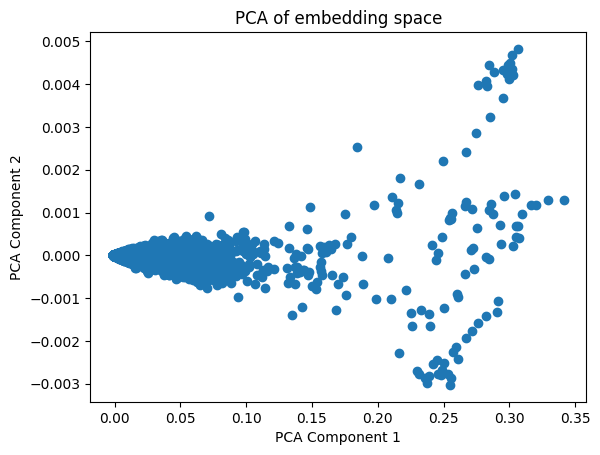

In [ ]:
from sklearn.decomposition import PCA

np_output = to_numpy(output.reshape(-1, 20))
pca = PCA(n_components=2)
pca_output = pca.fit_transform(np_output)

plt.scatter(pca_output[:, 0], pca_output[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of embedding space')
plt.show()

In [ ]:
for i in range(output.shape[-1]):
    source = output[0, ..., i]
    nussl.AudioSignal(audio_data_array=to_numpy(source), sample_rate=44100).embed_audio()

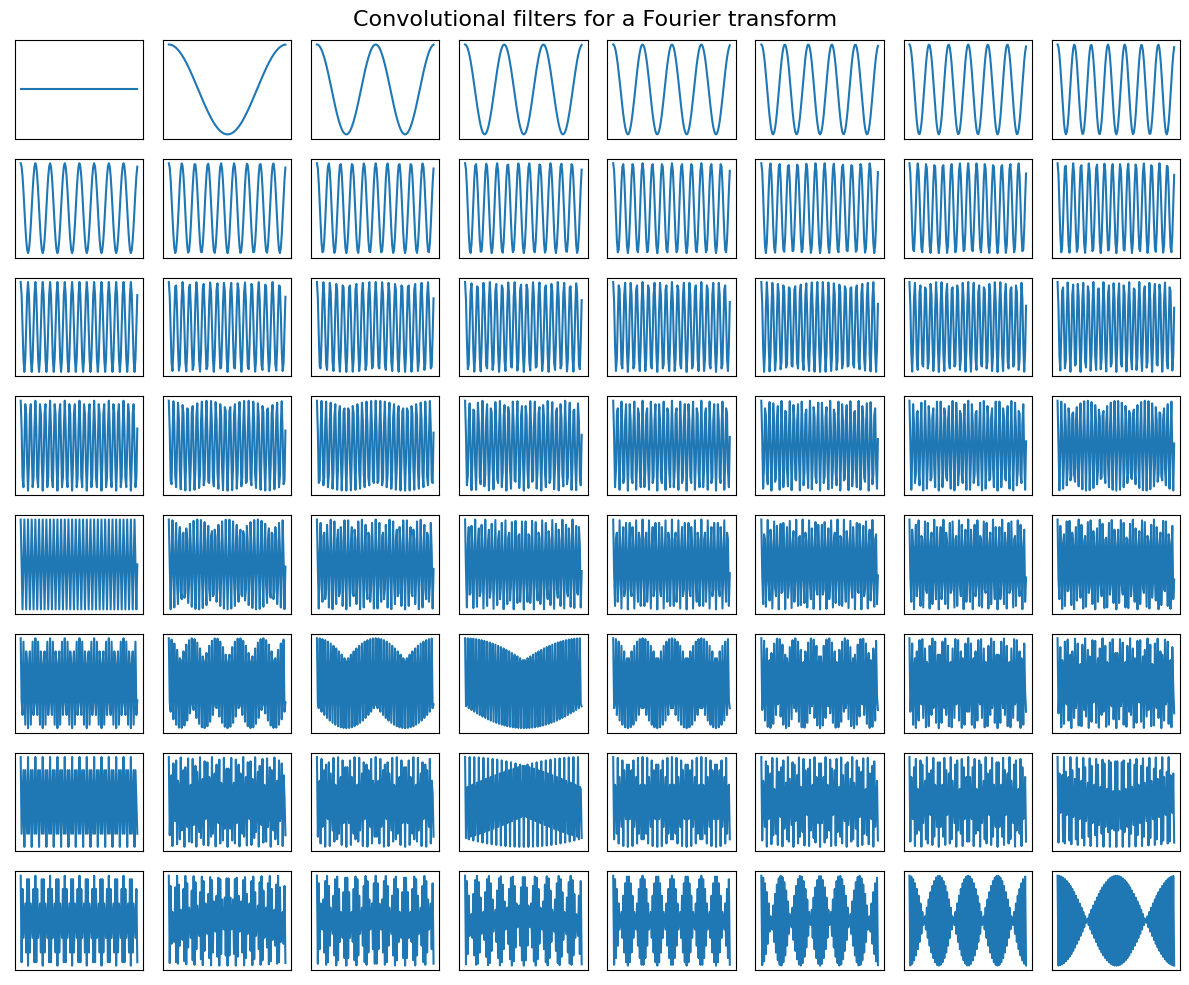

In [ ]:
filter_length = 128

fig, ax = plt.subplots(8, 8, figsize=(12, 10))
ax = ax.flatten()

fourier_basis = torch.fft.rfft(
    torch.eye(filter_length)
)
cutoff = 1 + filter_length // 2
fourier_basis = torch.cat([
    torch.real(fourier_basis[:, :cutoff]),
    torch.imag(fourier_basis[:, :cutoff])
], dim=1)
fourier_basis = fourier_basis.float()

for i in range(ax.shape[-1]):
    ax[i].plot(to_numpy(fourier_basis)[:, i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.suptitle('Convolutional filters for a Fourier transform', fontsize=16)
plt.tight_layout()
plt.show()

MOrew